In [1]:
import pyspark
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from nltk.corpus import stopwords
import nltk
import time
import pandas as pd

path_raw = "../../project/cmsc25025/stackexchange/20161215StatsPostsRaw.csv"  #Working file
path_mgd = "../../project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv"  #Working file

In [2]:
spark = SparkSession.builder.master('local[*]').appName('assn5_prob2').getOrCreate()
# Create new config, I'm using a 4 cpu, 4 tasks per node, 4 node machine
spark.conf.set("spark.executor.memory", '16g')
spark.conf.set("spark.driver.maxResultSize", "1g")
spark.conf.set("spark.driver.memory", "1g")

In [3]:
sc = spark.sparkContext

## Reduce vocabulary
1. Ignore first line: 'Id,CleanBody\n'
2. Remove first numbers from every line
3. Lowercase all words, take only words with positive length, remove punctuation at the end of every word
4. Filter words appearing at least 7 times (to get close to 10,000 words)

In [4]:
stop = stopwords.words("english")

In [5]:
sents = open(path_mgd, 'r').readlines()
sents = sents[1:]

In [6]:
sentences = sc.parallelize(sents)

In [7]:
min_ocurr = 7
PUNCTUATION = ',.()!?:;"\n-#$*%0123456789=_+&<>/\{[]}^' + "'"
t = time.time()


lines = sentences.map(lambda line: line.split(','))\
                 .map(lambda tup: (tup[0], tup[1].split(" ")))\
                 .map(lambda tup: (tup[0], [word.lower().strip(PUNCTUATION) for word in tup[1]]))
            
vocab = lines.flatMap(lambda tup: tup[1])\
             .map(lambda word: (word, 1))\
             .reduceByKey(lambda a, b: a + b) \
             .filter(lambda pair: pair[1] > min_ocurr and pair[0] not in stop and pair[0] != '') \
             .collectAsMap()
            
print(time.time()-t)

13.039137125


In [8]:
# Split data into train/test
y = 0.11
train, test = lines.randomSplit([1-y, y])
train.count(), test.count()

(82062, 10273)

In [9]:
len(vocab)

9599

In [10]:
voc = vocab.keys()
voc.sort()

In [11]:
WORD2IX = {}
IX2WORD = {}
for i, word in enumerate(voc):
    WORD2IX[word] = i
    IX2WORD[i] = word

In [12]:
voc

['@gung',
 '@whuber',
 "a's",
 'a*b',
 'a+b',
 'a-priori',
 'a.k.a',
 'a.s',
 'a/b',
 'aa',
 'ab',
 'abbreviated',
 'abc',
 'abilities',
 'ability',
 'able',
 'abnormal',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorbing',
 'abstract',
 'abundance',
 'abundances',
 'abuse',
 'ac',
 'academia',
 'academic',
 'academy',
 'accelerated',
 'acceleration',
 'accelerometer',
 'accept',
 'accept/reject',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accessible',
 'accessing',
 'accident',
 'accidents',
 'accommodate',
 'accompanying',
 'accomplish',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accounted',
 'accounting',
 'accounts',
 'accross',
 'accumulated',
 'accumulating',
 'accumulation',
 'accuracies',
 'accuracy',
 'accurate',
 'accurately',
 'ace',
 'aces',
 'acf',
 'acf/pacf',
 'achieve',
 'achieved',
 'achievement',
 'achieves',
 'achieving',
 'acoustic',
 'acquainted',
 'acquired',
 'acquiring',
 'acquisitio

## Fit topic models

In [13]:
from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector
from sklearn.model_selection import train_test_split

In [14]:
# We'll use these to preprocess data and put documents into sparse vectors with
# length len(voc) and counts on word appearance according to their occurrence

def words_to_vec(word_list):
    '''
    Takes:
        - word_list, a list of strings representing words
        - word_to_ix, an index with words as keys and value the index of its position in original data
        - sparse, a boolean indicating if vector is sparse or dense
    
    Returns:
        - rv, either a SparseVector of length=vocab size, and counts of occurrences of every
            word in word_list OR a dictionary with same counts (but not in a SparseVector representation)
    '''
    n = len(WORD2IX)
    rv = {}
    for word in word_list:
        if word not in WORD2IX:
            continue
        w = WORD2IX[word]
        if w not in rv:
            rv[w] = 0
        rv[w] += 1
    rv = SparseVector(n, rv)
    return rv

def num_text(line):
    '''
    Makes preprocessing easier, takes a string and returns a tuple with:
        - an int representing a document index
        - a string with text decoded into utf-8
    '''
    matches = re.findall(r'([0-9]+),(.*)', line)[0]
    return matches[0], matches[1].decode('utf-8')

def top_terms(topic_index_array):
    rv = []
    for i in topic_index_array:
        rv.append(IX2WORD[i])
    return rv

def get_top_n_topics(topic_matrix, n):
    rv = {}
    for i in range(k):
        temp = pd.DataFrame(topic_matrix[:,i])
        temp.sort_values(0, ascending=False, inplace=True)
        temp = temp.head(n)
        rv[i] = top_terms(temp.index)
    return rv

def remove_popular_words(top_topics, occurrence=0.5):
    n = len(top_topics)
    rv = {}
    for word_list in top_topics.values():
        for word in word_list:
            if word not in rv:
                rv[word] = 0
            rv[word] +=1
    only_x_perc = [x for x in rv.keys() if rv[x] < n*occurrence]
    more_x_perc = [x for x in rv.keys() if rv[x] >= n*occurrence]
    rv_without_popular = {tup[0]: [x for x in tup[1] if x in only_x_perc] for tup in top_topics.items()}
    rv_popular = {tup[0]: [x for x in tup[1] if x in more_x_perc] for tup in top_topics.items()}
    return rv_without_popular, rv_popular

In [15]:
train_vex = train.map(lambda tup: (tup[0], words_to_vec(tup[1])))
test_vex  = test.map(lambda tup: (tup[0], words_to_vec(tup[1])))

In [16]:
df = spark.createDataFrame(train_vex, ['id', 'features'])
df.cache()

DataFrame[id: string, features: vector]

In [17]:
lda = LDA(k=30, maxIter=30)
model = lda.fit(df)

In [18]:
topic_matrix = model.topicsMatrix()
topic_matrix = topic_matrix.toArray()
N, k = topic_matrix.shape
N, k

(9599, 30)

In [19]:
n = 15
top_topics = get_top_n_topics(topic_matrix, n)
topic_words, _ = remove_popular_words(top_topics, 0.15)

for i in range(len(topic_words)):
    print("Topic {}: \n{}\n".format(i, topic_words[i]))

Topic 0: 
['bayes', 'naive', 'norm', 'theorem', 'wishart', 'svd', 'matrices', 'covariance', 'classifier', 'tensor', 'rule', 'wells']

Topic 1: 
['date', 'interval', 'birth', 'genes', 'ci', 'replicates', 'confidence', 'bus', 'clinic', 'disease', 'surgery', 'diseases', 'heart', 'study']

Topic 2: 
['survey', 'scale', 'items', 'questions', 'analysis', 'likert', 'factor', 'different', 'questionnaire', 'item', 'people', 'variable', 'variables', 'multiple']

Topic 3: 
['outlier', 'multi-label', 'nonlinearity', 'novelty', 'smoking', 'budget', 'detection', 'pr', 'spot', 'x', 'quantity']

Topic 4: 
['survival', 'curve', 'odds', 'cox', 'fit', 'analysis', 'proportional', 'ratio', 'hazard', 'logistic', 'gibbs']

Topic 5: 
['garch', 'parzen', 'zip', 'inspecting', 'gradient', 'group', 'descent', 'window', 'premium', 'risk', 'mle', 'sample']

Topic 6: 
['probability', 'density', 'cdf', 'theorem', 'central', 'limit', 'random', 'moment', 'joint', 'dice', 'moments', 'die', 'cumulative']

Topic 7: 
['dis

With 30 topics, it seems that some selected topics might gravitate around certain well-defined subjectsÇ:
* Topic 2: Survey questionnaire design? Research words
* Topic 4: Models for logistic regression?
* Topic 9: Survival analysis (hazard rates, Box-Cox transform, etc)
* Topic 12: Not a clear topic. Random words.
* Topic 13: Probability words
* Topic 14: Statistical measures like coefficients of correlation, roc, precision, etc?.
* Topic 20: Linear algebra + random words
* Topic 28: Definitely Machine Learning algorithms, optimization, and regularization
* Topic 29: Stochastic processes?

In [21]:
print("Common words:\n")
for i in _.values():
    print(i)

Common words:

['distribution', 'data']
['data', 'using']
['data', 'test']
['data']
['regression', 'model', 'data', 'using', 'r', "i'm", 'use', 'two']
['data', 'test', 'using']
['random', 'data', 'r', 'distribution']
['regression', 'model']
['random', 'model']
['model', 'r', 'regression', 'using', "i'm", 'data', 'use']
['distribution', 'mean']
['data', 'regression']
['data', 'model', 'using', "i'm", 'r', 'random', 'use']
['distribution', 'random', 'mean']
['data', 'two', 'test', 'distribution', 'mean', 'use', 'using', "i'm"]
['data', 'model']
['data', 'two', 'use']
['test', 'data', 'r', 'using', 'use']
['using', 'regression', 'test', 'model']
['distribution']
['data', 'two']
['two', 'model']
['mean']
[]
[]
['random', 'data', 'regression']
["i'm"]
['data', 'use']
['mean', 'regression']
['data', 'two']


-> There are a lot of documents with "data, distribution, model, regression, I'm..." 

#### Select documents and determine the most probable topics for each of them (according to posterior distribution).

In [22]:
transformed = model.transform(df)

In [23]:
document_topics = transformed.rdd.map(lambda row: (row[0], row[2])).take(5)

doc_ids = []
doc_topics = []
doc_probs = []
for doc in document_topics:
    vec = doc[1]
    max_ix = 0
    max_val = 0
    for j in range(len(vec)):
        if vec[j] > max_val:
            max_val = vec[j]
            max_ix = j
    doc_ids.append(doc[0])
    doc_topics.append(max_ix)
    doc_probs.append(max_val)
    print("For document {}, most likely topic is {} with probability {}.".format(doc[0], max_ix, max_val))

For document 1, most likely topic is 14 with probability 0.448402955306.
For document 2, most likely topic is 14 with probability 0.951557637511.
For document 3, most likely topic is 9 with probability 0.725438668646.
For document 4, most likely topic is 14 with probability 0.979571019577.
For document 6, most likely topic is 12 with probability 0.713726691504.


In [20]:
for i in doc_ids:
    print(sents[int(i)-1][:1000])
    print('')

1,"Eliciting priors from experts How should I elicit prior distributions from experts when fitting a Bayesian model? John Cook gives some interesting recommendations. Basically, get percentiles/quantiles (not means or obscure scale parameters!) from the experts, and fit them with the appropriate distribution.    Eliciting priors is a tricky business.   Statistical Methods for Eliciting Probability Distributions and Eliciting Probability Distributions are quite good practical guides for prior elicitation.  The process in both papers is outlined as follows:  background and preparation; identifying and recruiting the expert(s); motivation and training the expert(s); structuring and decomposition (typically deciding precisely what variables should be elicited, and how to elicit joint distributions in the multivariate case); the elicitation itself. Of course, they also review how the elicitation results in information that may be fit to or otherwise define distributions (for instance, in th

** Comments: **
    
Appartently the 1st,2nd and 4th text are likely to be from the topic we cnames "Statistical Measures", which included terms like ROC and correlation. It's interesting to see that there are actually some terms related to the topic in the 2nd and 4th text that are not the same as those in the top words! (We only show first 1,000 characters in the texts) 

    1) This one doesn't include statistical measures, actually. But it does have some words from the topic 14 such as Bayesian, distribution, etc.
    2) normality, variance, kurtosis
    4) chi-square test, Kolmogorov-Smirnov test, location, 


### c) How does the perplexity for a single document relates to the definition of the inverse geometric mean of the predictions?

The perplexity of a set of documents: 

$$Perplexity(\theta) = \left ( \prod_D p_{\theta}(D) \right ) ^{-1/\Sigma_D|D|}$$

is basically the probability of finding, for every document, the probability of its words $ w_1, ..., w_D $. Given theta, the probability of the words of a document is just the multiplication of the probability of finding every word in the document. Therefore, since we just have a product of probabilities, we can rearrange them to express perplexity in terms of the product of finding all the words in all the documents.

$$Perplexity(\theta) = \left ( \prod_{n=1}^N p_{\theta}(w_n|w_1,...,w_{n-1}) \right ) ^{-1/N}$$

where N is the total number of words.

#### Mathematically, how would you evaluate the perplexity of the test set?
This would require to calculate the probability of generating words from the test set. Since we don't have topic mixtures for these held out documents, we could try using the parameters we got from training a posterior. This would be:

$$ p(w_{test}|\alpha, \beta) = \int p(\theta|\alpha) \left ( \prod_{n=1}^N p(w_{test,n}|\theta, \beta) \right ) d\theta $$

Where $w_{test}$ are the words in the test set and $\theta$ and $\beta$ are the parameters estimated with our training documents. This is again hard because we have that the probability of each one of the words is a multiple integral over the probabilities of the trained topics and the probabilities of words given topics:

$$ p(w|\alpha, \beta) = k \int \left ( \prod_{i=1}^k \theta_i^{\alpha_i-1} \right ) \left ( \prod_{n=1}^N \sum_{i=1}^k \prod_{j=1}^V (\theta_i\beta_{ij})^{w_n^j} \right ) d\theta $$

where the problem lies in summing over the latent topics and the coupling of $\theta$ and $\beta$.

A good way of approximating this probability could be using a Gibbs Sampling, as we've seen in class. And there are apparently more methods that according to Bleig, Ng, and Jordan (2003) could work, such as Laplace approximation and MCMC methods.

#### A computationally efficient approximation 
pyspark library for ml uses a formula by Hoffman 2010 (https://www.di.ens.fr/~fbach/mdhnips2010.pdf) (formula 16). For every word, a bound that is a function of sum of the expectations of the log of every word and the expectation of a variational distributions $q()$ times the counts of words. Since these have a closed-form solution, they are easier to compute.

## d) Evaluate perplexity with different clusters

In [17]:
df_test = spark.createDataFrame(test_vex, ['id', 'features'])
df_test.cache()

DataFrame[id: string, features: vector]

In [18]:
# Fit an LDA model
log_perplexity = []
for n_topics in range(10, 210, 10):
    t = time.time()
    lda = LDA(k=n_topics)
    model = lda.fit(df)
    print('Time spent fitting data for {} topics: {}'.format(n_topics, time.time()-t))
    lp = model.logPerplexity(df_test)
    log_perplexity.append(lp)
    print(' logPerplexity: {}'.format(lp))

Time spent fitting data for 10 topics: 20.1318640709
 logPerplexity: 8.06098728117
Time spent fitting data for 20 topics: 19.3830590248
 logPerplexity: 8.96779276336
Time spent fitting data for 30 topics: 19.0609061718
 logPerplexity: 10.0192937283
Time spent fitting data for 40 topics: 20.050896883
 logPerplexity: 11.261926804
Time spent fitting data for 50 topics: 20.9407231808
 logPerplexity: 12.5642244732
Time spent fitting data for 60 topics: 23.0241310596
 logPerplexity: 13.8999733858
Time spent fitting data for 70 topics: 24.4175441265
 logPerplexity: 15.4133316229
Time spent fitting data for 80 topics: 25.1133778095
 logPerplexity: 16.9078944514
Time spent fitting data for 90 topics: 26.7695739269
 logPerplexity: 18.5192737498
Time spent fitting data for 100 topics: 28.7752900124
 logPerplexity: 20.1121555977
Time spent fitting data for 110 topics: 29.8949980736
 logPerplexity: 21.7885649006


Traceback (most recent call last):
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
    self.process_request(request, client_address)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/software/pytho

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53348)
----------------------------------------


Py4JError: An error occurred while calling o532.fit

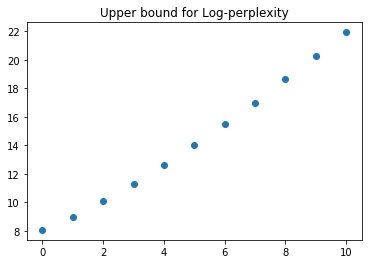

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(range(len(log_perplexity)), log_perplexity)
plt.title("Upper bound for Log-perplexity")

** Comments ** 

Lower perplexities indicate better model performance. In this case, we're having larger perplexities as we have more and more topics to model. This could be happening because of the way pyspark.ml.clustering calculates an upper bound on the perplexity. Given these, we could say that the best model is with only 10 topics.

(Also, sorry for the errors after 110 iterations, I tried to make it work but that kept happening :()